### Autoencoder

As the name suggest, autoencoder aims to learn encoding a representation of a training sample data automatically without human intervention. 

The autoencoder is widely used for dimensionality reduction and data de-nosing. 

Building an autoencoder will typically have three elements:

1) encoding function 
2) a decoding function and 
3) a loss function which is a distance function to measure the information loss between the compressed representation of data and the decompressed representation.

### Dimensionality reduction (Compress and De-compress) 

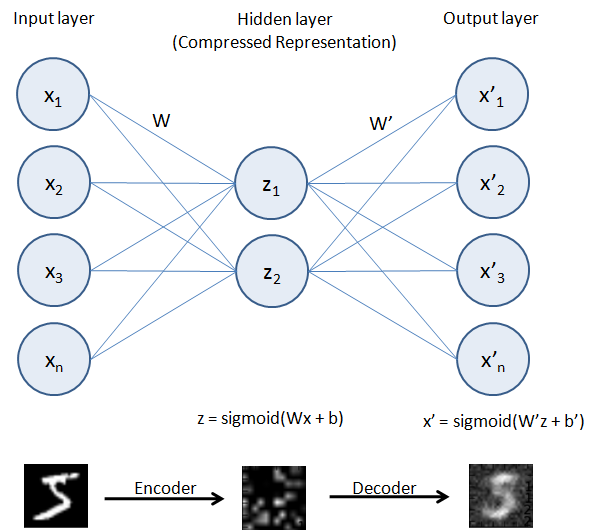

In [1]:
from IPython.display import Image
Image(filename='../Chapter 6 Figures/AutoEncoder_Diagram.png', width=500)

In [2]:
# Install graphviz and pydot-ng packages using below command
# sudo pip install graphviz
# sudo apt-get install graphviz
# pip install pydot-ng
import numpy as np
np.random.seed(2017)

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adadelta
from keras.utils import np_utils

# from keras.utils.visualize_util import plot
from IPython.display import SVG
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import model_to_dot

from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
# Image Dimension
input_unit_size = 28*28

# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# function to plot digits
def draw_digit(data, row, col, n):
    size = int(np.sqrt(data.shape[0]))
    plt.subplot(row, col, n)    
    plt.imshow(data.reshape(size, size))
    plt.gray()

In [5]:
# Normalize data
X_train = X_train.reshape(X_train.shape[0], input_unit_size)
X_train = X_train.astype('float32')
X_train /= 255

print('X_train shape:', X_train.shape)

X_train shape: (60000, 784)


### Construction Model

Instructions for updating:
Colocations handled automatically by placer.


/home/manohar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


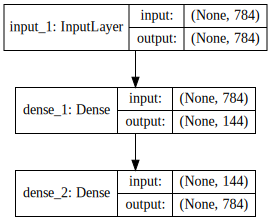

In [6]:
inputs = Input(shape=(input_unit_size,))
x = Dense(144, activation='relu')(inputs)
outputs = Dense(input_unit_size)(x)
model = Model(input=inputs, output=outputs)
model.compile(loss='mse', optimizer='adadelta')

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Note that 784 dimension is reduced through encoding to 144 in the hidden layer and again in layer 3 constructed back to 784 using decoder.

In [7]:
model.fit(X_train, X_train, epochs=5, batch_size=258)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
60000/60000 [==============================] - 2s 33us/step - loss: 0.0720
Epoch 2/5
60000/60000 [==============================] - 2s 29us/step - loss: 0.0550
Epoch 3/5
60000/60000 [==============================] - 2s 32us/step - loss: 0.0461
Epoch 4/5
60000/60000 [==============================] - 2s 31us/step - loss: 0.0402
Epoch 5/5
60000/60000 [==============================] - 2s 34us/step - loss: 0.0362


### Visualize input layer images

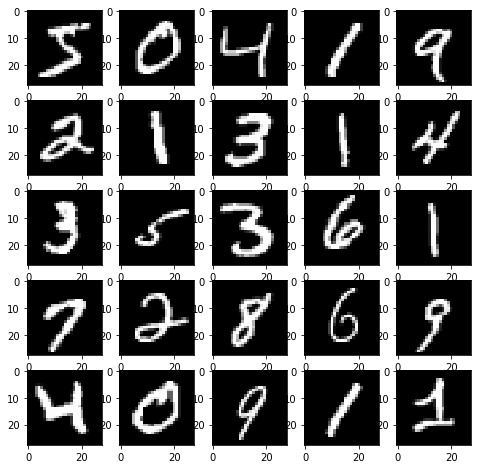

In [8]:
# plot the images from input layer
show_size = 5
total = 0
plt.figure(figsize=(8,8))
for i in range(show_size):
    for j in range(show_size):    
        draw_digit(X_train[total], show_size, show_size, total+1)
        total+=1
plt.show()

### Visualize hidden layer images (encoded / compressed)

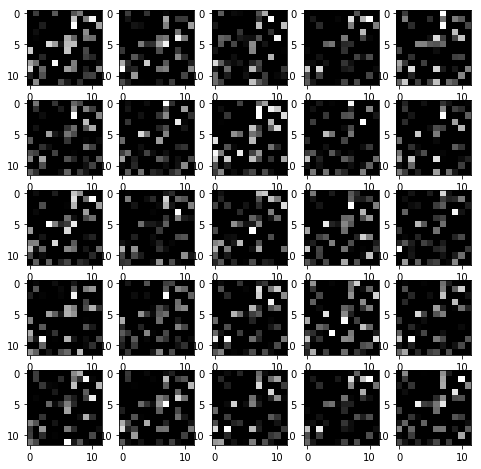

In [9]:
# plot the encoded (compressed) layer image
get_layer_output = K.function([model.layers[0].input], [model.layers[1].output])

hidden_outputs = get_layer_output([X_train[0:show_size**2]])[0]

total = 0
plt.figure(figsize=(8,8))
for i in range(show_size):
    for j in range(show_size):    
        draw_digit(hidden_outputs[total], show_size, show_size, total+1)
        total+=1
plt.show()

### Visualize output layer images (decoded / de-compressed)

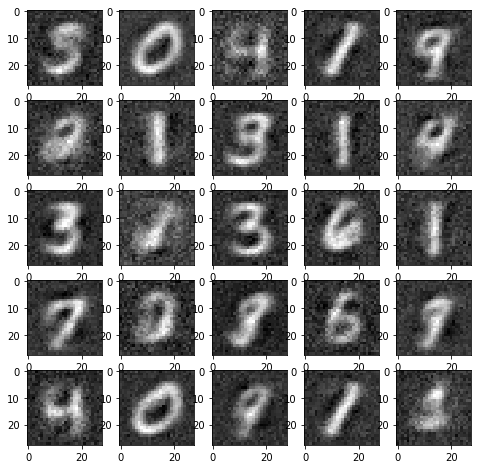

In [10]:
# Plot the decoded (de-compressed) layer images
get_layer_output = K.function([model.layers[0].input], [model.layers[2].output])

last_outputs = get_layer_output([X_train[0:show_size**2]])[0]

total = 0
plt.figure(figsize=(8,8))
for i in range(show_size):
    for j in range(show_size):    
        draw_digit(last_outputs[total], show_size, show_size, total+1)
        total+=1
plt.show()

### Denoise Image

Discovering robust features from the compressed hidden layer is an important aspect to enable autoencoder to efficiently reconstruct the input from a de-noised version or original image. This is addressed by the de-noising auto-encoder, which is a stochastic version of auto-encoder.

Let's introduce some noisy to the digit dataset and try to build a model to denoise the image

In [11]:
# Introducing noise to the image
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_train_noisy = np.clip(X_train_noisy, 0., 1.)

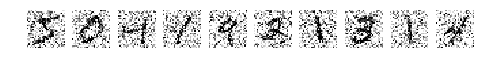

In [12]:
# Function for visualization
def draw(data, row, col, n):
    plt.subplot(row, col, n)    
    plt.imshow(data, cmap=plt.cm.gray_r)
    plt.axis('off')
    
show_size = 10
plt.figure(figsize=(8,8))

for i in range(show_size):
    draw(X_train_noisy[i].reshape(28,28), 1, show_size, i+1)
plt.show()

Fit a model on noisy train data

Epoch 1/5
60000/60000 [==============================] - 5s 82us/step - loss: 0.0469
Epoch 2/5
60000/60000 [==============================] - 5s 83us/step - loss: 0.0423
Epoch 3/5
60000/60000 [==============================] - 5s 82us/step - loss: 0.0399
Epoch 4/5
60000/60000 [==============================] - 5s 86us/step - loss: 0.0381
Epoch 5/5
60000/60000 [==============================] - 5s 81us/step - loss: 0.0366


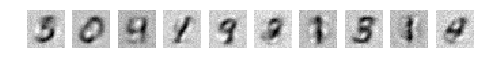

In [13]:
model.fit(X_train_noisy, X_train, epochs=5, batch_size=258)

# Prediction for denoised image
X_train_pred = model.predict(X_train_noisy)

show_size = 10
plt.figure(figsize=(8,8))

for i in range(show_size):
    draw(X_train_pred[i].reshape(28,28), 1, show_size, i+1)
plt.show()

Note that we can tune the model to get improve the sharpness of denoised image